In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shapely.ops as so
import shapely.geometry as sg
%matplotlib widget

# TODO: Create grains
# TODO: Polish

In [2]:
class Grain(object):
    """ Stores grain information and plot representation """

    def __init__(self, xy=[]):
        # Data
        self.centroid = 0
        self.id = 0
        self.xy = xy

        # Display
        self.normal_props = {
            'alpha': 0.6
        }
        self.selected_props = {
            'alpha': 1.0,
            'facecolor': 'red'
        }
        self.ax = None
        self.patch = None
        self.selected = False
    
    def make_patch(self, ax):
        self.ax = ax
        (self.patch,) = ax.fill(
            *self.xy,
            edgecolor='black',
            linewidth=5.0,
            picker=True,
            **self.normal_props
        )
        self.normal_props['facecolor'] = self.patch.get_facecolor()
        return self.patch

    def select(self):
        self.selected = ~self.selected
        props = self.selected_props if self.selected else self.normal_props
        self.patch.set(**props)
        return self.selected


class GrainPlot(object):
    """ Interactive plot to create, delete, and merge grains """

    def __init__(self, grains, image=None, predictor=None):
        self.image = image
        self.predictor = predictor
        
        self.fig = plt.figure(figsize=(6, 4))
        self.ax = self.fig.add_subplot(aspect='equal')
        # self.ax.set_xticks([])
        # self.ax.set_yticks([])
        self.canvas = self.fig.canvas

        self.left_cursor = patches.Circle((0, 0), radius=0.05, color='lime', visible=False)
        self.right_cursor = patches.Circle((0, 0), radius=0.05, color='red', visible=False)
        self.ax.add_patch(self.left_cursor)
        self.ax.add_patch(self.right_cursor)

        self.cids = []
        self.selected_grains = []

        self.grains = grains
        for grain in grains:
            grain.make_patch(self.ax)

    # Helper functions ---
    def set_cursor(self, cursor, xy):
        if xy:
            cursor.set_center(xy)
            cursor.set_visible(True)
        else:
            cursor.set_center((-1, -1))
            cursor.set_visible(False)

    def unselect_cursors(self):
        self.set_cursor(self.left_cursor, False)
        self.set_cursor(self.right_cursor, False)

    def unselect_grains(self):
        for grain in self.selected_grains:
            grain.select()
        self.selected_grains = []

    def unselect_all(self):
        self.unselect_cursors()
        self.unselect_grains()

    # Manage grains ---
    def create_grain(self, event):
        """ Attempt to find and add grain at selected point """
        # Verify that we've actually selected something
        if not self.left_cursor.visible:
            return
        xy_left = self.left_cursor.get_center()
        # Two-point prompt (grain and background)
        if self.right_cursor.visible:
            xy_right = self.right_cursor.get_center()
            xy = seg.two_point_prompt(*xy_right, *xy_left, self.image, self.predictor)
        # One-point prompt (grain only)
        else:
            x, y, mask = seg.one_point_prompt(*xy_left, self.image, self.predictor)
            xy = (x, y)
        # Add grain to plot
        grain = Grain(xy)
        grain.make_patch(self.ax)
        # Add grain to list
        self.grains.append(grain)
        # Reset pointers
        self.unselect_cursors()

    def delete_grains(self):
        """ Delete all selected grains """
        for grain in self.selected_grains:
            # Hide grain from plot
            grain.patch.remove()
            # Delete grain from list
            self.grains.remove(grain)
        self.selected_grains = []

    def merge_grains(self):
        """ Merge all selected grains """
        # Verify there are at least two grains to merge
        if len(self.selected_grains) < 2:
            return
        # Find vertices of merged grains using Shapely
        polys = [sg.Polygon(g.patch.get_path().vertices) for g in self.selected_grains]
        poly = so.unary_union(polys)
        # Verify that grains actually overlap, otherwise reset selection
        if isinstance(poly, sg.MultiPolygon):
            self.unselect_all()
            return
        # Make new grain
        new_grain = Grain(poly.exterior.xy)
        self.grains.append(new_grain)
        new_grain.make_patch(self.ax)
        # Clear old grains
        self.delete_grains()

    # Events ---
    def onclick(self, event):
        """ Handle clicking anywhere on plot """
        # Only process individual clicks, only when no grains selected
        if event.dblclick is True or len(self.selected_grains) > 0:
            return
        # Grain prompt (left click)
        if event.button == 1:
            self.set_cursor(self.left_cursor, (event.xdata, event.ydata))
        # Background prompt (right click)
        elif event.button == 3:
            self.set_cursor(self.right_cursor, (event.xdata, event.ydata))

    def onpick(self, event):
        """ Handle clicking on an existing grain """
        # Only process individual left-clicks
        if event.mouseevent.dblclick or event.mouseevent.button != 1:
            return
        # Hide cursors
        self.unselect_cursors()
        # Add selected grain to list
        for grain in self.grains:
            if event.artist is grain.patch:
                if grain.select():
                    self.selected_grains.append(grain)
                else:
                    self.selected_grains.remove(grain)
                break
    
    def onpress(self, event):
        """ Handle key presses """
        if event.key == 'c':
            self.create_grain()
        elif event.key == 'delete':
            self.delete_grains()
        elif event.key == 'm':
            self.merge_grains()
        elif event.key == 'escape':
            self.unselect_all()

    def activate(self):
        events = {
            'button_press_event': self.onclick,
            'pick_event': self.onpick,
            'key_press_event': self.onpress
        }
        for event, handler in events.items():
            self.cids.append(self.canvas.mpl_connect(event, handler))

    def deactivate(self):
        for cid in self.cids:
            self.canvas.mpl_disconnect(cid)
        self.cids = []


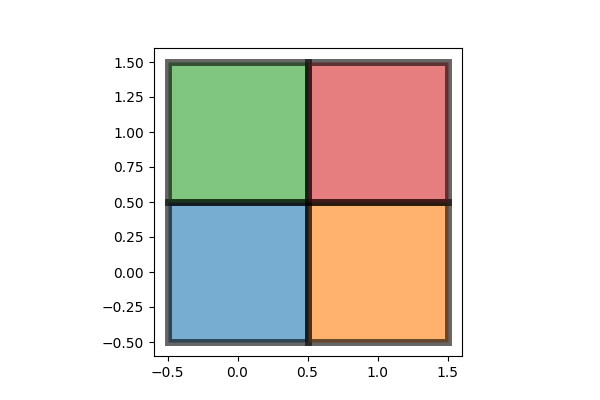

In [3]:
# Make grains
grains = []
centroids = [(0, 0), (1, 0), (0, 1), (1, 1)]
for c in centroids:
    x, y = c
    x = [x-0.5, x+0.5, x+0.5, x-0.5]
    y = [y+0.5, y+0.5, y-0.5, y-0.5]
    grains.append(Grain([x, y]))

# Plot grains
grain_plot = GrainPlot(grains)
grain_plot.activate()